# Statistical analysis of orthopedic features

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, poisson, norm, t, ttest_ind
import pymc3 as pm
from numpy.random import seed
from scipy import stats

In [160]:
df = pd.read_csv('Data/data.csv')
X = pd.read_csv('Data/X.csv')
Y1 = pd.read_csv('Data/Y1.csv')
Y2 = pd.read_csv('Data/Y2.csv')
columns = X.columns
a, b = X.shape
  # ac is in TensorFlow format
Tdata = np.c_[np.ones((a, 1)), X]

### Look at correlations and perform feature selection

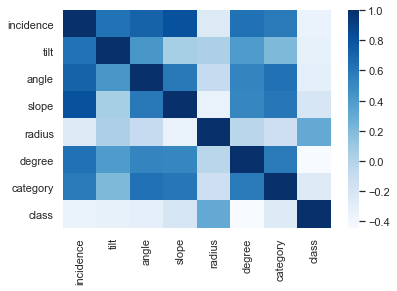

In [77]:
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(df.corr(), cmap="Blues")

Looking at correlation between 1) features and 2) targets we have a couple actions to follow up with<br><br>1) Since we do not want too much correlation between features, we should look at slope vs incidence to ensure it is not >90%.  We want to remove any features with >=90% correlation so they do not interfere with the model.<br><br>2) for the targets "class" and "category" we don't see the correlation we would like between class and the features which is contrary to basic instincts, let's look deeper at these correlations.

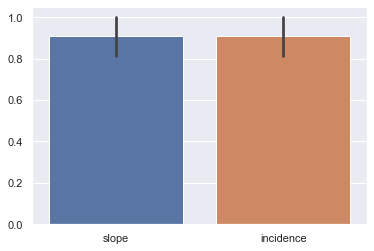

In [78]:
two = df[['slope','incidence']]
ax = sns.barplot(data=two.corr())

Pretty close to 90%- below is a test for correlation and removal of features that are >=90%

In [64]:
# Select and remove features that have >90% correlation with each other
corr = X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
data = X[selected_columns]

Looks like they all passed, but I would note this very close correlation and test the model without 'slope' to test for interference.  <br><br>next we can look at target variables 'class' and 'category' in seaborn correlations to confirm what is suspected, that 'category' may be a better target feature.

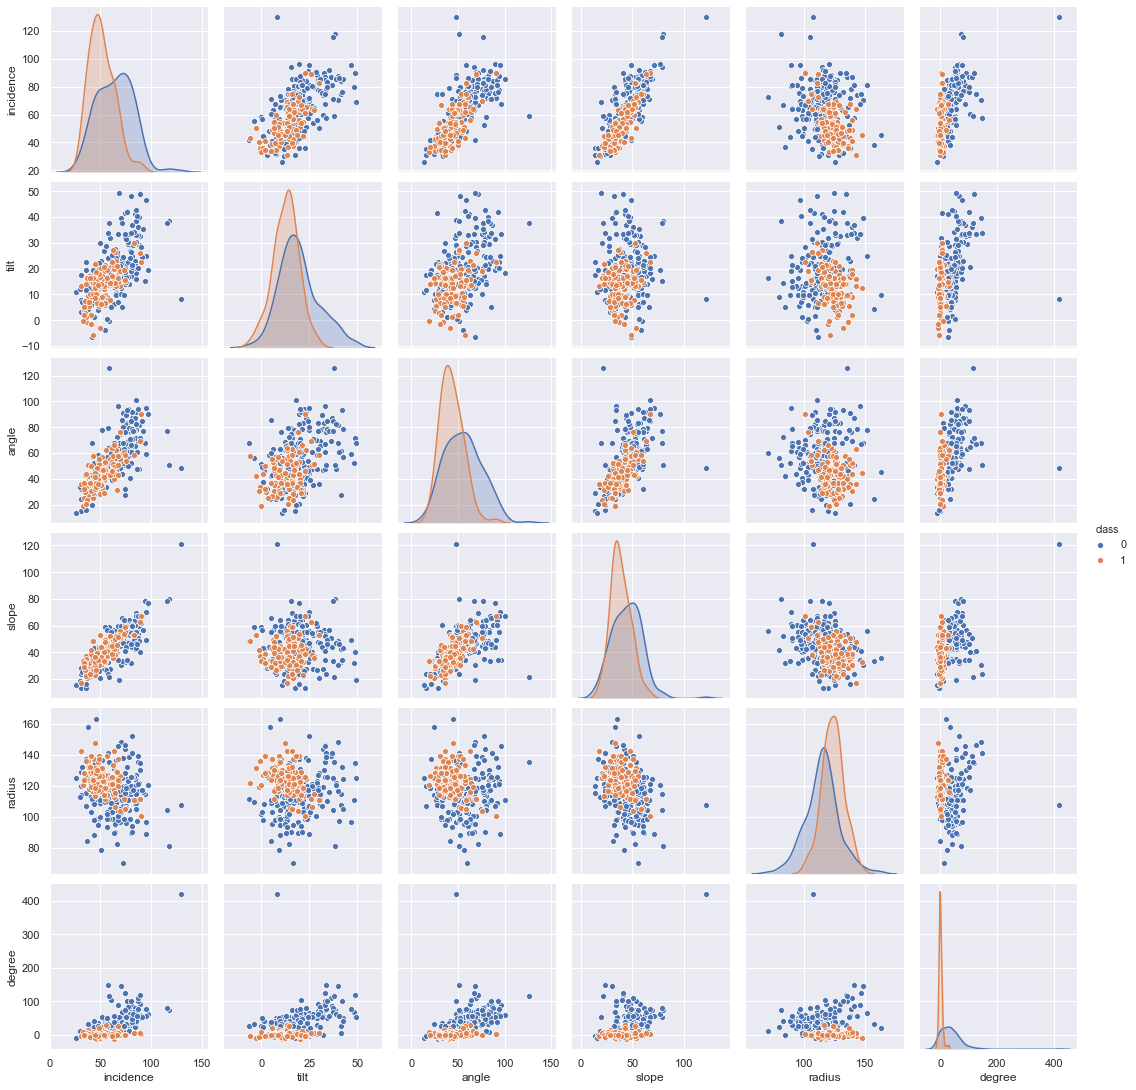

In [65]:
# Correlation graph for the target "Class" only

seaborn = df.drop(['category'], axis=1)
sns.pairplot(seaborn, hue="class")
plt.show()

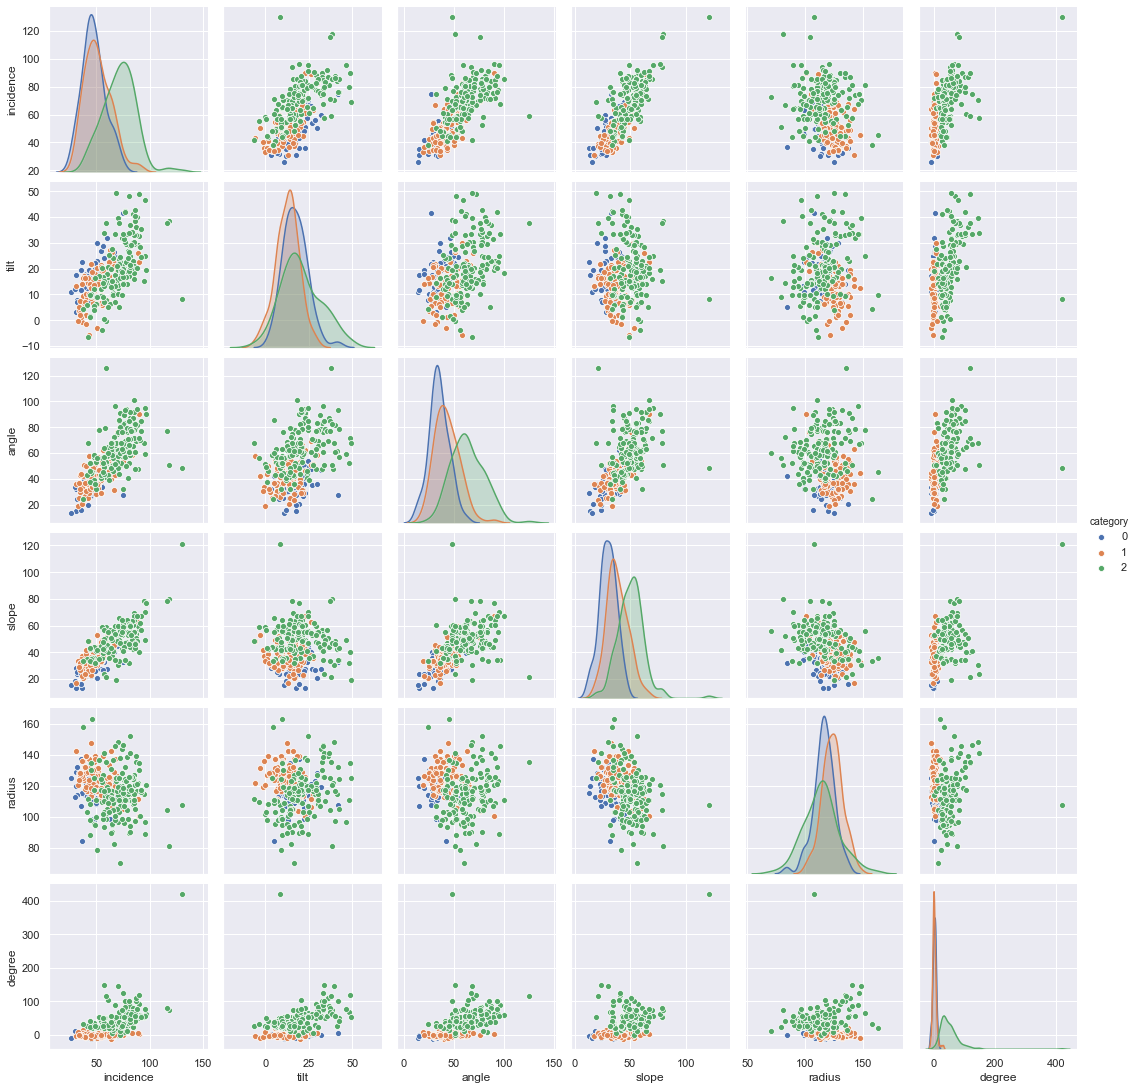

In [66]:
# Correlation graph for the target "Class" only

seaborn = df.drop(['class'], axis=1)
sns.pairplot(seaborn, hue="category")
plt.show()

What we are seeing is a comparison between 1) Abnormal/Normal to 2) Normal/Hernia/Spondylolisthesis.  We can see the overlap of herniated disc and spondylolesthesis and expect this overlap to cause the most interference with results.  Radius and Tilt seem to have alot of overlap with all features except degree, since degree has great separation/correlation with all features it recommend testing the model with and without radius & tilt.

Text(0.5, 1.02, 'how')

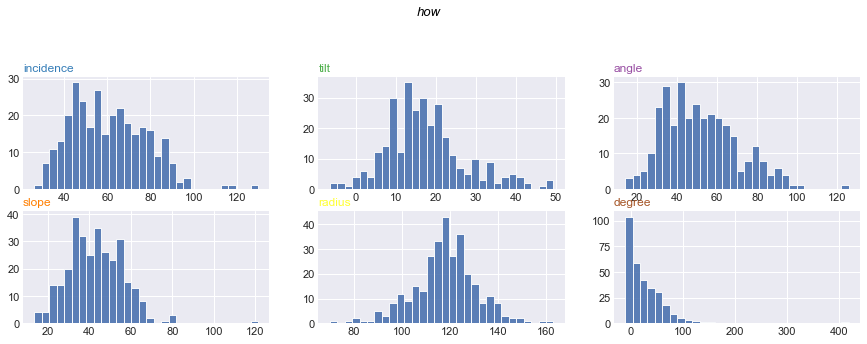

In [67]:
sns.set(rc={'figure.figsize':(15,7)})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0
for column in X:
    num+=1
    plt.subplot(3,3, num)
    plt.hist(df[column], bins=30, alpha=0.9, label=column)
#    plt.xlim(0,10)
#    plt.ylim(-2,22)
    
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
    
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))

plt.suptitle("how", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

The degree has a gamma/lognormal distribution while the other features have various normal distributions.  Let's look at the cdf's and pdf's after some bootstrapping since the data is pretty small.

In [115]:
norm_degree =df[df['class'] == 0]['degree']
abn_degree = df[df['class'] == 1]['degree']

In [116]:
norm_degree =df[df['category'] == 0]['degree']
h_degree = df[df['category'] == 1]['degree']
s_degree = df[df['category'] == 2]['degree']

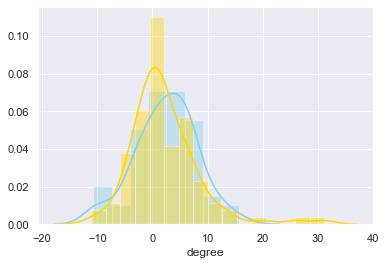

In [117]:
sns.distplot( norm_degree, color='skyblue', label='degree')
sns.distplot( abn_degree, color='gold', label='degree')

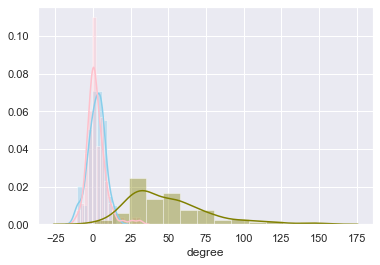

In [118]:
sns.distplot( norm_degree, color='skyblue', label='degree')
sns.distplot( h_degree, color='pink', label='degree')
sns.distplot( s_degree, color='olive', label='degree')

In [119]:
norm_radius =df[df['class'] == 0]['radius']
abn_radius = df[df['class'] == 1]['radius']

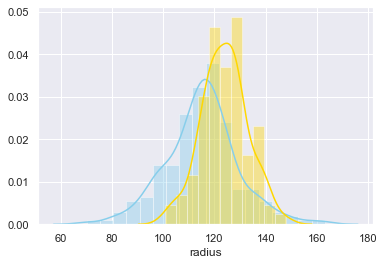

In [120]:
sns.distplot( norm_radius, color='skyblue', label='radius')
sns.distplot( abn_radius, color='gold', label='radius')

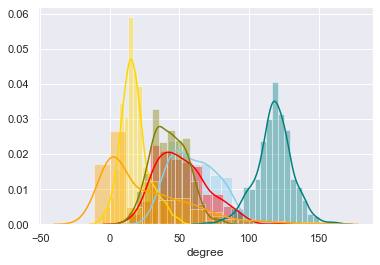

In [104]:

sns.distplot( df['incidence'], color='skyblue', label='degree')
sns.distplot( df['tilt'], color='gold', label='degree')
sns.distplot( df['angle'], color='red', label='degree')
sns.distplot( df['slope'], color='olive', label='degree')
sns.distplot( df['radius'], color='teal', label='degree')
sns.distplot( df['degree'], color='orange', label='degree')

plt.show()

In [130]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [138]:
def plot_ecdf(a, b):
    x, y = ecdf(a)
    t, u = ecdf(b)
        # Plot the CDF with axis labels
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.plot(t, u, marker='.', linestyle='none')
    _ = plt.xlabel('Measure')
    _ = plt.ylabel('CDF')

        # Show the plot
    plt.show()

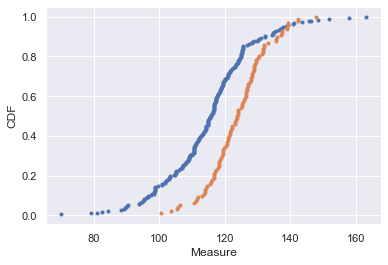

In [139]:
plot_ecdf(norm_radius, abn_radius)

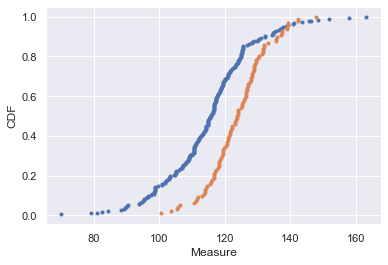

In [140]:
plot_ecdf(norm_radius, abn_radius)

### Statistical Significance

Setting the p-value test to 0.5 it can be seen below that all features demonstrate signficance and pass the hypotheses test using ttest from scipy.stats to calulate against class

In [197]:
columns = ['incidence','angle','slope','degree','tilt','radius']
def test(y, var):
    for column in columns:
        a, b = stats.ttest_ind(y,X[column], equal_var = var)
        print("The p-value for ",column,":  ",np.mean(b))

In [199]:
print("P-values for the Class target vs all Features: ",test(Y1,False))

The p-value for  incidence :   1.4546759956331843e-177
The p-value for  angle :   4.098548220478672e-147
The p-value for  slope :   1.2978731917764568e-169
The p-value for  degree :   3.688655294450916e-36
The p-value for  tilt :   1.95195811457888e-94
The p-value for  radius :   6.375984197796973e-295
P values for the Class target vs all Features:  None


In [200]:
print("P-values for the Category target vs all Features: ",test(Y2,False))

The p-value for  incidence :   9.147843746516067e-176
The p-value for  angle :   5.333967073148655e-145
The p-value for  slope :   4.014317390845837e-167
The p-value for  degree :   4.658786404222277e-34
The p-value for  tilt :   7.7193919961656e-89
The p-value for  radius :   1.2082641747608714e-294
P-values for the Category target vs all Features:  None


In [201]:
print("P-values for the Radius target vs all Features: ",test(X[['radius']],False))

The p-value for  incidence :   4.585775729676822e-202
The p-value for  angle :   2.5626475768336805e-211
The p-value for  slope :   1.9665876707156713e-301
The p-value for  degree :   5.858462871485352e-178
The p-value for  tilt :   0.0
The p-value for  radius :   1.0
P-values for the Radius target vs all Features:  None


In [202]:
print("P-values for the Tilt target vs all Features: ",test(X[['tilt']],False))

The p-value for  incidence :   2.0567136676661206e-151
The p-value for  angle :   2.769929364605397e-105
The p-value for  slope :   1.1843221868627964e-106
The p-value for  degree :   4.771155769398115e-05
The p-value for  tilt :   1.0
The p-value for  radius :   0.0
P-values for the Tilt target vs all Features:  None


In [207]:
print("P-values for the Slope target vs all Features: ",test(X[['slope']],False))

The p-value for  incidence :   1.2836950497963163e-41
The p-value for  angle :   1.7337990532928204e-12
The p-value for  slope :   1.0
The p-value for  degree :   2.0909117429984466e-19
The p-value for  tilt :   1.1843221868627964e-106
The p-value for  radius :   1.9665876707156713e-301
P-values for the Slope target vs all Features:  None


In [208]:
print("P-values for the Degree target vs all Features: ",test(X[['degree']],False))

The p-value for  incidence :   2.3358777602086048e-55
The p-value for  angle :   5.159656663523279e-35
The p-value for  slope :   2.0909117429984466e-19
The p-value for  degree :   1.0
The p-value for  tilt :   4.771155769398115e-05
The p-value for  radius :   5.858462871485352e-178
P-values for the Degree target vs all Features:  None


In [209]:
print("P-values for the Incidence target vs all Features: ",test(X[['incidence']],False))

The p-value for  incidence :   1.0
The p-value for  angle :   8.289127898850462e-09
The p-value for  slope :   1.2836950497963163e-41
The p-value for  degree :   2.3358777602086048e-55
The p-value for  tilt :   2.0567136676661206e-151
The p-value for  radius :   4.585775729676822e-202
P-values for the Incidence target vs all Features:  None


In [210]:
print("P-values for the Angle target vs all Features: ",test(X[['angle']],False))

The p-value for  incidence :   8.289127898850462e-09
The p-value for  angle :   1.0
The p-value for  slope :   1.7337990532928204e-12
The p-value for  degree :   5.159656663523279e-35
The p-value for  tilt :   2.769929364605397e-105
The p-value for  radius :   2.5626475768336805e-211
P-values for the Angle target vs all Features:  None


### MACHINE LEARNING

#### Note: tilt and slope are equally correlated, excluding either does not appear to impact score.

In [328]:
# Report lists many scores to be used during parameter tuning
def report_scores(data_Y, predicted):
    print("accuracy",metrics.accuracy_score(data_Y, predicted))
    print("f1 score macro",metrics.f1_score(data_Y, predicted, average='macro')) 
    print("f1 score micro",metrics.f1_score(data_Y, predicted, average='micro')) 
    print("precision score",metrics.precision_score(data_Y, predicted, average='macro')) 
    print("recall score",metrics.recall_score(data_Y, predicted, average='macro')) 
    print("hamming_loss",metrics.hamming_loss(data_Y, predicted))
    print("classification_report", metrics.classification_report(data_Y, predicted))
    print("jaccard_similarity_score", metrics.jaccard_score(data_Y, predicted))
    print("log_loss", metrics.log_loss(data_Y, predicted))
    print("zero_one_loss", metrics.zero_one_loss(data_Y, predicted))
    print("AUC&ROC",metrics.roc_auc_score(data_Y, predicted))
    print("matthews_corrcoef", metrics.matthews_corrcoef(data_Y, predicted))

### Logistic Regression

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split(df[['degree', 'incidence', 'angle', 'radius', 'tilt', 'slope']].values, 
                                              (df[['class']] == "Abnormal").values,random_state=5)

ytrain = np.ravel(ytrain) # optimize the shape of y

clf = LogisticRegression(solver='lbfgs')
clf.fit(xtrain, ytrain)


# Print the accuracy from the testing data.
print("Initial accuracy score for Logistic Regression: ", accuracy_score(clf.predict(xtest), ytest))

Initial accuracy score for Logistic Regression:  0.8717948717948718


In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#### Performing a KFold split of 5 results in same accuracy

In [44]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 6
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [45]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, xtrain, ytrain)
print(score)
print("Initial accuracy score for Logistic Regression: ", accuracy_score(clf.predict(xtest), ytest))

0.8488529014844803
Initial accuracy score for Logistic Regression:  0.8717948717948718


#### Performing a GridSearch to optimize the C parameter...

In [46]:
from sklearn.model_selection import GridSearchCV
def cv_optimize(clf, parameters, xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [47]:
parameters = {"C": [0.0001, 0.001, 0.1, 0.5, 1, 10]}
print(cv_optimize(clf, parameters, xtrain, ytrain, n_folds=5))

BEST PARAMS {'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [167]:
# Run LogisticRegression with optimized C parameter
clfl2=LogisticRegression(solver='lbfgs',C=0.1)
ytest = np.ravel(ytest)
clfl2.fit(xtest, ytest)
ypred2=clfl2.predict(xtest)
accuracy_score(ypred2, ytest)
report_scores(data_Y, ypred2)

accuracy 0.8717948717948718
f1 score macro 0.8627726952850105
f1 score micro 0.8717948717948718
precision score 0.8685714285714285
recall score 0.8583333333333334
hamming_loss 0.1282051282051282
classification_report               precision    recall  f1-score   support

       False       0.86      0.80      0.83        30
        True       0.88      0.92      0.90        48

    accuracy                           0.87        78
   macro avg       0.87      0.86      0.86        78
weighted avg       0.87      0.87      0.87        78

jaccard_similarity_score 0.8148148148148148
log_loss 4.428109763252411
zero_one_loss 0.1282051282051282
AUC&ROC 0.8583333333333333
matthews_corrcoef 0.7268326590665243


### Gaussian Naive Bayes

In [113]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(xtrain,ytrain)
y_model = model.predict(xtest)
print("Accuracy for Gaussian Naive Bayes: ", accuracy_score(y_model, ytest))

Accuracy for Gaussian Naive Bayes:  0.7564102564102564


In [114]:
from sklearn.preprocessing import StandardScaler
ss_xtest = StandardScaler().fit_transform(xtest)
ss_xtrain = StandardScaler().fit_transform(xtrain)

### KNeighborsClassifier

#### After turning n_neighbors to 10, accuracy results are the same as Logistic Regression

In [204]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(xtrain,ytrain)
y_pred = knn.predict(xtest)
print("Accuracy for K Nearest Neighbors: ", accuracy_score(ytest, y_pred))

Accuracy for K Nearest Neighbors:  0.8717948717948718


In [227]:
model = KNeighborsClassifier()
model.fit(xtrain,ytrain)
KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=10, p=1, weights='uniform')

kn_pred = model.predict(xtest)

In [228]:
report_scores(data_Y, kn_pred)

accuracy 0.8076923076923077
f1 score macro 0.7955617683033374
f1 score micro 0.8076923076923077
precision score 0.7976776917663617
recall score 0.79375
hamming_loss 0.19230769230769232
classification_report               precision    recall  f1-score   support

       False       0.76      0.73      0.75        30
        True       0.84      0.85      0.85        48

    accuracy                           0.81        78
   macro avg       0.80      0.79      0.80        78
weighted avg       0.81      0.81      0.81        78

jaccard_similarity_score 0.7321428571428571
log_loss 6.642154393629512
zero_one_loss 0.1923076923076923
AUC&ROC 0.7937500000000001
matthews_corrcoef 0.5914146496540943


In [265]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, random_state=1)
rfc.fit(xtrain, ytrain)
ypred = rfc.predict(xtest)
print(metrics.accuracy_score(ytest, rfc.predict(xtest)))


0.8333333333333334


In [271]:
def randomforest(xtrain, ytrain, xtest, scores):
    rfc = RandomForestClassifier(n_estimators=10)
    rfc.fit(xtrain, ytrain)
    ypred = rfc.predict(xtest)
    scores.append(metrics.accuracy_score(ytest, rfc.predict(xtest)))

In [272]:
trials = range(1,100)
accuracyscores = []
for i in trials:
    randomforest(xtrain, ytrain, xtest, accuracyscores)
 #   accuracyscores.append(scores)

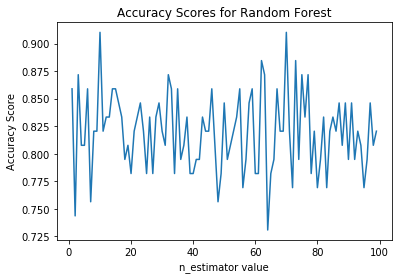

In [276]:
plt.plot(range(1,100),accuracyscores)
plt.xlabel('n_estimator value')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Random Forest')
plt.show()

In [283]:
rfc = RandomForestClassifier(n_estimators=12)
rfc.fit(xtrain, ytrain)
ypred = rfc.predict(xtest)
print(metrics.accuracy_score(ytest, rfc.predict(xtest)))

0.9358974358974359


In [331]:
report_scores(ytest, ypred)

accuracy 0.9358974358974359
f1 score macro 0.9308878256246678
f1 score micro 0.9358974358974359
precision score 0.9422657952069716
recall score 0.9229166666666666
hamming_loss 0.0641025641025641
classification_report               precision    recall  f1-score   support

       False       0.96      0.87      0.91        30
        True       0.92      0.98      0.95        48

    accuracy                           0.94        78
   macro avg       0.94      0.92      0.93        78
weighted avg       0.94      0.94      0.94        78

jaccard_similarity_score 0.9038461538461539
log_loss 2.214065132875311
zero_one_loss 0.0641025641025641
AUC&ROC 0.9229166666666666
matthews_corrcoef 0.8649660707556456
